# Designing model for Optic Fiber Network fault detection, localization, and identification

## Data Handling

Imports:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import trange
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, auc,
                             precision_recall_curve,
                             confusion_matrix, classification_report,
                             mean_squared_error)
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

Data Loading:

In [3]:
data_dir = "./data/OTDR_data.csv"
data = pd.read_csv(data_dir)

In [4]:
data.head()

Unnamed: 0        SNR        P1        P2        P3        P4        P5  \
0       70519  10.093627  0.989995  0.769634  0.866942  1.000000  0.838370   
1       81009   0.219347  0.341150  0.484929  0.689960  0.924820  0.648481   
2       62575   9.282432  0.438344  0.981339  0.728630  0.485106  0.359851   
3       70401   8.803449  0.674877  0.638932  0.651814  0.716335  0.475147   
4        7550  16.485467  0.767071  0.517559  0.115700  0.000000  0.055019   

         P6        P7        P8  ...       P25       P26       P27       P28  \
0  0.795462  0.801609  0.763259  ...  0.345600  0.114946  0.000000  0.381516   
1  0.196055  0.886128  1.000000  ...  0.384524  0.992029  0.488258  0.402361   
2  0.184697  0.222956  0.437243  ...  0.910126  0.964232  0.637623  0.162285   
3  0.628348  0.626998  0.691957  ...  0.411247  0.097255  0.210350  0.263302   
4  0.258061  0.115876  0.392273  ...  0.457824  0.864551  0.704364  0.508301   

        P29       P30  Class  Position  Reflectance   loss  
0  0.099061  0.280784    1.0      0.08          0.0  0.112  
1  0.321495  0.679280    3.0      0.11          0.0  0.400  
2  0.138643  0.723457    0.0      0.00          0.0  0.000  
3  0.132508  0.000000    1.0      0.09          0.0  0.100  
4  0.433237  0.028219    0.0      0.00          0.0  0.000  

[5 rows x 36 columns]

In [5]:
print(list(data.columns))

['Unnamed: 0', 'SNR', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'Class', 'Position', 'Reflectance', 'loss']


In [6]:
counts = (
    data['Class']
      .value_counts()
      .reindex(range(8), fill_value=0)
      .sort_index()
)

print(counts)

Class
0    16048
1    16000
2    16000
3    16000
4    16000
5    13849
6    16000
7    15935
Name: count, dtype: int64


Even class distribution, with 8 classes (0-7).

In [7]:
data.drop(columns=["Unnamed: 0"], inplace=True)

In [8]:
import hvplot.pandas
data.hvplot.scatter(x='SNR', y='Position', c='Class', cmap='coolwarm',
                    title='SNR vs Position by Class', width=800)

:Scatter   [SNR]   (Position,Class)

In [9]:
data.describe()

SNR             P1             P2             P3  \
count  125832.000000  125832.000000  125832.000000  125832.000000   
mean       12.315957       0.383666       0.379560       0.377179   
std         9.202129       0.343306       0.338766       0.336568   
min         0.000000       0.000000       0.000000       0.000000   
25%         3.000000       0.041760       0.038821       0.036689   
50%        13.000000       0.320210       0.315812       0.310499   
75%        20.106899       0.690142       0.685213       0.681227   
max        30.000000       1.000000       1.000000       1.000000   

                  P4             P5             P6             P7  \
count  125832.000000  125832.000000  125832.000000  125832.000000   
mean        0.375738       0.376254       0.382815       0.390346   
std         0.332489       0.326922       0.324796       0.319550   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.040424       0.051494       0.061802       0.079696   
50%         0.308350       0.313471       0.333092       0.351876   
75%         0.669226       0.660253       0.662213       0.658540   
max         1.000000       1.000000       1.000000       1.000000   

                  P8             P9  ...            P25            P26  \
count  125832.000000  125832.000000  ...  125832.000000  125832.000000   
mean        0.399960       0.412891  ...       0.476285       0.456533   
std         0.315327       0.312780  ...       0.296303       0.296518   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.090327       0.103174  ...       0.233595       0.215426   
50%         0.372897       0.397047  ...       0.441615       0.416618   
75%         0.664620       0.676426  ...       0.714035       0.683525   
max         1.000000       1.000000  ...       1.000000       1.000000   

                 P27            P28            P29            P30  \
count  125832.000000  125832.000000  125832.000000  125832.000000   
mean        0.437593       0.420615       0.402363       0.389017   
std         0.294765       0.293194       0.295106       0.306531   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.203007       0.192505       0.169732       0.144702   
50%         0.391529       0.366709       0.347401       0.332184   
75%         0.656642       0.635709       0.617000       0.609878   
max         1.000000       1.000000       1.000000       1.000000   

               Class       Position    Reflectance           loss  
count  125832.000000  125832.000000  125832.000000  125832.000000  
mean        3.471216       0.059272      -0.070685       0.222031  
std         2.302075       0.043066       0.092539       0.271161  
min         0.000000       0.000000      -0.300000       0.000000  
25%         1.000000       0.030000      -0.130000       0.000000  
50%         3.000000       0.060000       0.000000       0.092000  
75%         6.000000       0.090000       0.000000       0.400000  
max         7.000000       0.200000       0.000000       1.000000  

[8 rows x 35 columns]

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125832 entries, 0 to 125831
Data columns (total 35 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   SNR          125832 non-null  float64
 1   P1           125832 non-null  float64
 2   P2           125832 non-null  float64
 3   P3           125832 non-null  float64
 4   P4           125832 non-null  float64
 5   P5           125832 non-null  float64
 6   P6           125832 non-null  float64
 7   P7           125832 non-null  float64
 8   P8           125832 non-null  float64
 9   P9           125832 non-null  float64
 10  P10          125832 non-null  float64
 11  P11          125832 non-null  float64
 12  P12          125832 non-null  float64
 13  P13          125832 non-null  float64
 14  P14          125832 non-null  float64
 15  P15          125832 non-null  float64
 16  P16          125832 non-null  float64
 17  P17          125832 non-null  float64
 18  P18          125832 non-

In [11]:
data.isnull().sum()

SNR            0
P1             0
P2             0
P3             0
P4             0
P5             0
P6             0
P7             0
P8             0
P9             0
P10            0
P11            0
P12            0
P13            0
P14            0
P15            0
P16            0
P17            0
P18            0
P19            0
P20            0
P21            0
P22            0
P23            0
P24            0
P25            0
P26            0
P27            0
P28            0
P29            0
P30            0
Class          0
Position       0
Reflectance    0
loss           0
dtype: int64

No null values found in the dataset.

In [12]:
print(data.shape)

(125832, 35)


In [13]:
train, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Class'])

In [14]:
print(train.shape, test_data.shape)

(100665, 35) (25167, 35)


In [15]:
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42, stratify=train['Class'])

In [16]:
print(train_data.shape, val_data.shape)

(80532, 35) (20133, 35)


In [17]:
print(test_data['Class'].value_counts().sort_index())

Class
0.0    3210
1.0    3200
2.0    3200
3.0    3200
4.0    3200
5.0    2770
6.0    3200
7.0    3187
Name: count, dtype: int64


In [18]:
print(train_data['Class'].value_counts().sort_index())

Class
0.0    10270
1.0    10240
2.0    10240
3.0    10240
4.0    10240
5.0     8863
6.0    10240
7.0    10199
Name: count, dtype: int64


In [19]:
print(val_data['Class'].value_counts().sort_index())

Class
0.0    2568
1.0    2560
2.0    2560
3.0    2560
4.0    2560
5.0    2216
6.0    2560
7.0    2549
Name: count, dtype: int64


### Setting up the data for training

In [20]:
measurement_cols = [c for c in data.columns
                    if c.startswith('P') and c[1:].isdigit()]
measurement_cols += ['SNR']
X_train = train_data[measurement_cols].values.astype(np.float32)                          # (N, 31)
Y_train_class = train_data['Class'].astype(np.int64).values                        # categorical fault label
Y_train_position = train_data['Position'].astype(np.float32).values.reshape(-1, 1)

In [21]:
print(measurement_cols)

['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'SNR']


In [22]:
X_val = val_data[measurement_cols].values.astype(np.float32)                          # (N, 31)
Y_val_class = val_data['Class'].astype(np.int64).values                        # categorical fault label
Y_val_position = val_data['Position'].astype(np.float32).values.reshape(-1, 1)

In [23]:
X_test = test_data[measurement_cols].values.astype(np.float32)                          # (N, 31)
Y_test_class = test_data['Class'].astype(np.int64).values                        # categorical fault label
Y_test_position = test_data['Position'].astype(np.float32).values.reshape(-1, 1)

In [24]:
print(X_train.shape, Y_train_class.shape, Y_train_position.shape)

(80532, 31) (80532,) (80532, 1)


In [25]:
print(X_val.shape, Y_val_class.shape, Y_val_position.shape)

(20133, 31) (20133,) (20133, 1)


In [26]:
print(X_test.shape, Y_test_class.shape, Y_test_position.shape)

(25167, 31) (25167,) (25167, 1)


In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)     # fit ONLY on training data
X_val   = scaler.transform(X_val)           # transform validation
X_test  = scaler.transform(X_test)          # transform test

Making Tensors

In [28]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val,   dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32)

y_class_train_tensor = torch.tensor(Y_train_class, dtype=torch.long)
y_class_val_tensor   = torch.tensor(Y_val_class,   dtype=torch.long)
y_class_test_tensor  = torch.tensor(Y_test_class,  dtype=torch.long)

y_pos_train_tensor = torch.tensor(Y_train_position, dtype=torch.float32)
y_pos_val_tensor   = torch.tensor(Y_val_position,   dtype=torch.float32)
y_pos_test_tensor  = torch.tensor(Y_test_position,  dtype=torch.float32)

## Model Functions

### GRU-AE

Checking CUDA:

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [79]:
print("PyTorch version:", torch.__version__)
print("Built with CUDA:", torch.version.cuda)
print("cuda.is_available():", torch.cuda.is_available())

PyTorch version: 2.5.1+cu121
Built with CUDA: 12.1
cuda.is_available(): True


Defining the GRU-AE and training it on normal traces:

In [80]:
NORMAL_LABEL = 0
idx_norm = (y_class_train_tensor == NORMAL_LABEL).nonzero(as_tuple=True)[0]

X_train_norm = X_train_tensor[idx_norm]           # shape (N_norm, 31)
train_loader_ae = DataLoader(X_train_norm, batch_size=256, shuffle=True, drop_last=True)

In [81]:
class VectorGRUAE(nn.Module):
    def __init__(self, feat_dim=31, hidden=128, latent=64, layers=3):
        super().__init__()
        self.encoder = nn.GRU(feat_dim, hidden, layers, batch_first=True, bidirectional=False)
        self.fc_mu  = nn.Linear(hidden, latent)
        self.fc_init= nn.Linear(latent, hidden*layers)
        self.decoder= nn.GRU(feat_dim, hidden, layers, batch_first=True)
        self.out    = nn.Linear(hidden, feat_dim)

    def forward(self, x):                # x (B, 1, 31)
        _, h_enc = self.encoder(x)
        z   = self.fc_mu(h_enc[-1])      # (B, latent)
        h0  = self.fc_init(z).view(self.decoder.num_layers, x.size(0), -1).contiguous()
        dec, _ = self.decoder(x, h0)
        return self.out(dec)

In [82]:
feat_dim = X_train_tensor.shape[1]
ae = VectorGRUAE(feat_dim=feat_dim, hidden=128, latent=64, layers=3).to(device)
opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)

best_val, patience, PAT_MAX = 1e9, 0, 10
# training loop
for epoch in range(120):
    ae.train(); tr_loss = 0
    for xb in train_loader_ae:
        xb = xb.unsqueeze(1).to(device)           # (B,1,31)
        loss = loss_fn(ae(xb), xb)
        opt.zero_grad(); loss.backward(); opt.step()
        tr_loss += loss.item()*xb.size(0)

    # quick validation
    ae.eval()
    with torch.no_grad():
        samp = X_val_tensor[:5000].unsqueeze(1).to(device)
        val_loss = loss_fn(ae(samp), samp).item()

    print(f'E{epoch:02d}  trainMSE={tr_loss/len(train_loader_ae.dataset):.5f} ' f'valMSE={val_loss:.5f}')
    scheduler.step()

    if val_loss < best_val:
        best_val, patience = val_loss, 0
        torch.save(ae.state_dict(), 'models/gru_ae_deep.pt')
    else:
        patience += 1
        if patience == PAT_MAX:
            print('Early stopping'); break

E00  trainMSE=0.59491 valMSE=0.46101
E01  trainMSE=0.34195 valMSE=0.22201
E02  trainMSE=0.16290 valMSE=0.06235
E03  trainMSE=0.03857 valMSE=0.01643
E04  trainMSE=0.00901 valMSE=0.01281
E05  trainMSE=0.00681 valMSE=0.01194
E06  trainMSE=0.00588 valMSE=0.01135
E07  trainMSE=0.00518 valMSE=0.01110
E08  trainMSE=0.00467 valMSE=0.01043
E09  trainMSE=0.00421 valMSE=0.00983
E10  trainMSE=0.00377 valMSE=0.00934
E11  trainMSE=0.00358 valMSE=0.00887
E12  trainMSE=0.00342 valMSE=0.00853
E13  trainMSE=0.00326 valMSE=0.00833
E14  trainMSE=0.00311 valMSE=0.00778
E15  trainMSE=0.00298 valMSE=0.00759
E16  trainMSE=0.00285 valMSE=0.00717
E17  trainMSE=0.00273 valMSE=0.00709
E18  trainMSE=0.00261 valMSE=0.00696
E19  trainMSE=0.00251 valMSE=0.00686
E20  trainMSE=0.00238 valMSE=0.00659
E21  trainMSE=0.00231 valMSE=0.00649
E22  trainMSE=0.00227 valMSE=0.00645
E23  trainMSE=0.00222 valMSE=0.00620
E24  trainMSE=0.00217 valMSE=0.00609
E25  trainMSE=0.00212 valMSE=0.00599
E26  trainMSE=0.00208 valMSE=0.00588
E

Evaluating GRU-AE:

GRU-AE Threshold: 0.004


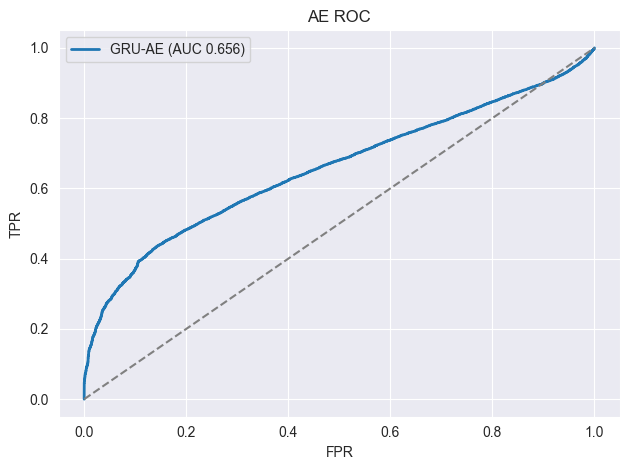

In [83]:
ae.load_state_dict(torch.load('models/gru_ae_deep.pt', map_location=device, weights_only=True))

def recon_err_vec(model, data, bs=512):
    model.eval(); errs=[]
    with torch.no_grad():
        for i in range(0, data.size(0), bs):
            x = data[i:i+bs].unsqueeze(1).to(device)
            errs.append(((model(x)-x)**2).mean(dim=(1,2)).cpu())
    return torch.cat(errs)

err_train = recon_err_vec(ae, X_train_norm)
threshold = torch.quantile(err_train, 0.98).item()
print(f'GRU-AE Threshold: {threshold:.3f}')

err_eval  = recon_err_vec(ae, torch.cat([X_val_tensor, X_test_tensor]))
y_eval    = (torch.cat([y_class_val_tensor, y_class_test_tensor]) != 0).numpy()

from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_eval, err_eval.numpy()); A = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'GRU-AE (AUC {A:.3f})')
plt.plot([0,1],[0,1],'--', c='grey'); plt.legend()
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('AE ROC'); plt.tight_layout()
plt.show()


Classification report:
               precision    recall  f1-score   support

      Normal       0.17      0.93      0.28      5778
     Anomaly       0.97      0.31      0.47     39522

    accuracy                           0.39     45300
   macro avg       0.57      0.62      0.38     45300
weighted avg       0.87      0.39      0.45     45300



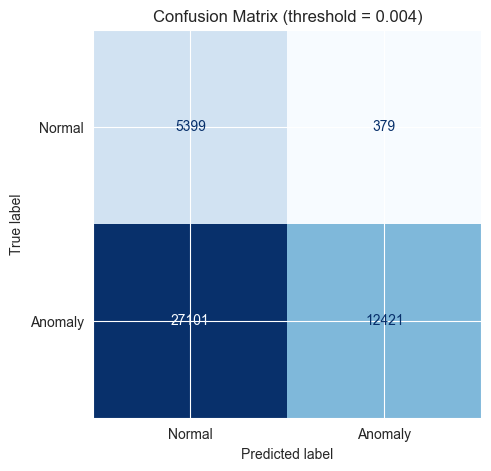

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = (err_eval.numpy() > threshold).astype(int)
y_true = y_eval.astype(int)

cm = confusion_matrix(y_true, y_pred)

print("\nClassification report:\n",
      classification_report(y_true, y_pred, target_names=['Normal','Anomaly']))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Normal','Anomaly'])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title(f'Confusion Matrix (threshold = {threshold:.3f})')
plt.tight_layout()
plt.show()


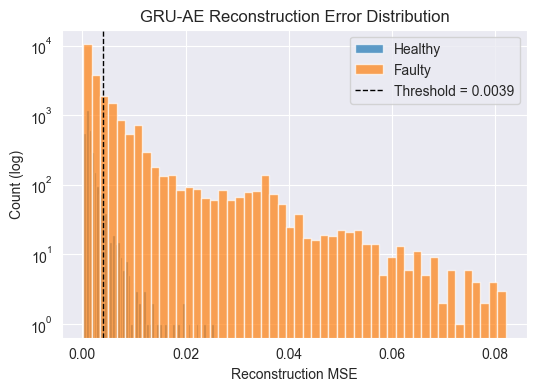

In [85]:
ae.eval()
test_ds  = TensorDataset(X_test_tensor,  y_class_test_tensor,  y_pos_test_tensor.squeeze(-1))
test_loader = DataLoader(test_ds, batch_size=256)
with torch.no_grad():
    recon_err = []
    for x in test_loader:
        x = x[0].to(device).unsqueeze(1)     # (B, 1, D)
        recon = ae(x)
        mse = (recon - x).pow(2).mean(dim=(1,2))  # per-sample error
        recon_err.append(mse.cpu())
recon_err = torch.cat(recon_err).numpy()

y_true_det = (y_class_test_tensor != NORMAL_LABEL).numpy().astype(int)  # 1 = fault, 0 = healthy
y_score_det = recon_err


plt.figure(figsize=(6,4))
plt.hist(recon_err[y_true_det==0], bins=50, alpha=0.7, label='Healthy')
plt.hist(recon_err[y_true_det==1], bins=50, alpha=0.7, label='Faulty')
plt.axvline(threshold, color='k', linestyle='--', linewidth=1,
            label=f'Threshold = {threshold:.4f}')
plt.yscale('log')
plt.xlabel('Reconstruction MSE'); plt.ylabel('Count (log)')
plt.title('GRU-AE Reconstruction Error Distribution')
plt.legend(); plt.show()


In [86]:
def reconstruction_errors_cond(batch_X, bs=512):
    amp_all, snr_all = batch_X[:, :30], batch_X[:, 30]
    errs = []
    ae.eval()
    with torch.no_grad():
        for i in range(0, batch_X.size(0), bs):
            amp = amp_all[i:i+bs].unsqueeze(-1).to(device)   # (B,30,1)
            snr = snr_all[i:i+bs].to(device)                # (B,)
            recon = ae(amp, snr)
            mse   = (recon - amp).pow(2).mean(dim=(1, 2))   # (B,)
            errs.append(mse.cpu())
    return torch.cat(errs)

def detect(batch_X, thresh=threshold):
    errs = reconstruction_errors_cond(batch_X)
    return errs > thresh

### TCN

TCN model definition:

In [87]:
class Chomp1d(nn.Module):
    def __init__(self, chomp):
        super().__init__(); self.chomp = chomp
    def forward(self, x):
        return x[:, :, :-self.chomp].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k, d):
        super().__init__()
        pad = (k - 1) * d
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, k, padding=pad, dilation=d),
            Chomp1d(pad), nn.ReLU(),
            nn.Conv1d(out_ch, out_ch, k, padding=pad, dilation=d),
            Chomp1d(pad), nn.ReLU()
        )
        self.down = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.net(x) + self.down(x))

class OTDR_TCN(nn.Module):
    def __init__(self, in_ch=1, mid_ch=64, n_blocks=5, k=3, n_classes=4):
        super().__init__()
        layers = []
        ch = in_ch
        for b in range(n_blocks):
            layers.append(TemporalBlock(ch, mid_ch, k, 2 ** b))
            ch = mid_ch
        self.tcn = nn.Sequential(*layers)
        self.gap = nn.AdaptiveAvgPool1d(1)      # global average over length

        # multitask heads
        self.class_head = nn.Linear(mid_ch, n_classes)
        self.loc_head   = nn.Linear(mid_ch, 1)

    def forward(self, x):            # x: (B, 1, L)
        h = self.tcn(x)
        h = self.gap(h).squeeze(-1)  # (B, mid_ch)
        return self.class_head(h), self.loc_head(h).squeeze(-1)

In [88]:
batch_size = 256

train_ds = TensorDataset(X_train_tensor, y_class_train_tensor, y_pos_train_tensor.squeeze(-1))
val_ds   = TensorDataset(X_val_tensor,   y_class_val_tensor,   y_pos_val_tensor.squeeze(-1))
test_ds  = TensorDataset(X_test_tensor,  y_class_test_tensor,  y_pos_test_tensor.squeeze(-1))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)

Training the TCN model:

In [89]:
n_fault_classes = int(y_class_train_tensor.max() + 1)

tcn = OTDR_TCN(in_ch=1,
               mid_ch=64,
               n_blocks=6,
               k=3,
               n_classes=n_fault_classes).to(device)

criterion_cls = nn.CrossEntropyLoss()
criterion_loc = nn.MSELoss()
lambda_loc = 0.5                              # scale for regression term

opt_tcn = torch.optim.Adam(tcn.parameters(), lr=1e-3)


In [90]:
num_epochs_tcn = 50
best_val_loss, patience, patience_max = float('inf'), 0, 10

for epoch in trange(num_epochs_tcn, desc='TCN'):
    # training loop
    tcn.train()
    t_loss = 0.
    for x, y_cls, y_loc in train_loader:
        x   = x.unsqueeze(1).to(device)         # (B, 1, L)
        y_c = y_cls.to(device)
        y_l = y_loc.to(device)

        logits, pred_loc = tcn(x)
        loss = criterion_cls(logits, y_c) + lambda_loc * criterion_loc(pred_loc, y_l)
        opt_tcn.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(tcn.parameters(), 1.0)
        opt_tcn.step()
        t_loss += loss.item() * x.size(0)

    # validation loop
    tcn.eval()
    v_loss, v_correct, v_samples, v_mse_sum = 0., 0, 0, 0.
    with torch.no_grad():
        for x, y_cls, y_loc in val_loader:
            x   = x.unsqueeze(1).to(device)
            y_c = y_cls.to(device)
            y_l = y_loc.to(device)

            logits, pred_loc = tcn(x)
            loss = criterion_cls(logits, y_c) + lambda_loc * criterion_loc(pred_loc, y_l)
            v_loss += loss.item() * x.size(0)

            v_correct += (logits.argmax(1) == y_c).sum().item()
            v_mse_sum += criterion_loc(pred_loc, y_l).item() * x.size(0)
            v_samples += x.size(0)

    v_loss /= v_samples
    v_acc  = v_correct / v_samples
    v_rmse = (v_mse_sum / v_samples) ** 0.5

    print(f'Epoch {epoch+1:02d} | train L={t_loss/len(train_ds):.4f} | '
          f'val L={v_loss:.4f} | val Acc={v_acc:.3f} | val RMSE={v_rmse:.3f}')

    # ---- early stopping ----
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(tcn.state_dict(), 'models/best_tcn.pt')
        patience = 0
    else:
        patience += 1
        if patience >= patience_max:
            print('Early stopping.')
            break


TCN:   2%|▏         | 1/50 [00:04<03:56,  4.83s/it]

Epoch 01 | train L=1.1229 | val L=0.9497 | val Acc=0.631 | val RMSE=0.067


TCN:   4%|▍         | 2/50 [00:09<03:39,  4.56s/it]

Epoch 02 | train L=0.8515 | val L=0.7877 | val Acc=0.686 | val RMSE=0.076


TCN:   6%|▌         | 3/50 [00:13<03:35,  4.59s/it]

Epoch 03 | train L=0.7660 | val L=0.7119 | val Acc=0.723 | val RMSE=0.104


TCN:   8%|▊         | 4/50 [00:18<03:31,  4.59s/it]

Epoch 04 | train L=0.6860 | val L=0.6471 | val Acc=0.758 | val RMSE=0.187


TCN:  10%|█         | 5/50 [00:22<03:22,  4.49s/it]

Epoch 05 | train L=0.6061 | val L=0.5904 | val Acc=0.778 | val RMSE=0.109


TCN:  12%|█▏        | 6/50 [00:27<03:15,  4.43s/it]

Epoch 06 | train L=0.4973 | val L=0.4574 | val Acc=0.823 | val RMSE=0.107


TCN:  14%|█▍        | 7/50 [00:31<03:12,  4.49s/it]

Epoch 07 | train L=0.4258 | val L=0.4071 | val Acc=0.839 | val RMSE=0.137


TCN:  16%|█▌        | 8/50 [00:39<03:58,  5.67s/it]

Epoch 08 | train L=0.4040 | val L=0.4318 | val Acc=0.822 | val RMSE=0.077


TCN:  18%|█▊        | 9/50 [00:44<03:44,  5.47s/it]

Epoch 09 | train L=0.3817 | val L=0.3731 | val Acc=0.854 | val RMSE=0.077


TCN:  20%|██        | 10/50 [00:49<03:30,  5.27s/it]

Epoch 10 | train L=0.3686 | val L=0.3652 | val Acc=0.857 | val RMSE=0.070


TCN:  22%|██▏       | 11/50 [00:54<03:15,  5.00s/it]

Epoch 11 | train L=0.3536 | val L=0.3538 | val Acc=0.854 | val RMSE=0.065


TCN:  24%|██▍       | 12/50 [00:58<03:01,  4.79s/it]

Epoch 12 | train L=0.3493 | val L=0.3586 | val Acc=0.854 | val RMSE=0.072


TCN:  26%|██▌       | 13/50 [01:02<02:50,  4.61s/it]

Epoch 13 | train L=0.3329 | val L=0.3781 | val Acc=0.850 | val RMSE=0.056


TCN:  28%|██▊       | 14/50 [01:06<02:41,  4.49s/it]

Epoch 14 | train L=0.3276 | val L=0.3376 | val Acc=0.862 | val RMSE=0.097


TCN:  30%|███       | 15/50 [01:11<02:34,  4.42s/it]

Epoch 15 | train L=0.3206 | val L=0.3431 | val Acc=0.867 | val RMSE=0.163


TCN:  32%|███▏      | 16/50 [01:15<02:27,  4.35s/it]

Epoch 16 | train L=0.3133 | val L=0.3353 | val Acc=0.862 | val RMSE=0.059


TCN:  34%|███▍      | 17/50 [01:19<02:23,  4.36s/it]

Epoch 17 | train L=0.3042 | val L=0.3476 | val Acc=0.858 | val RMSE=0.057


TCN:  36%|███▌      | 18/50 [01:23<02:17,  4.30s/it]

Epoch 18 | train L=0.2970 | val L=0.3236 | val Acc=0.869 | val RMSE=0.053


TCN:  38%|███▊      | 19/50 [01:27<02:11,  4.24s/it]

Epoch 19 | train L=0.2973 | val L=0.3522 | val Acc=0.859 | val RMSE=0.062


TCN:  40%|████      | 20/50 [01:32<02:09,  4.32s/it]

Epoch 20 | train L=0.2872 | val L=0.3131 | val Acc=0.873 | val RMSE=0.052


TCN:  42%|████▏     | 21/50 [01:36<02:04,  4.28s/it]

Epoch 21 | train L=0.2810 | val L=0.2982 | val Acc=0.878 | val RMSE=0.051


TCN:  44%|████▍     | 22/50 [01:40<02:00,  4.32s/it]

Epoch 22 | train L=0.2749 | val L=0.2952 | val Acc=0.879 | val RMSE=0.051


TCN:  46%|████▌     | 23/50 [01:45<01:57,  4.35s/it]

Epoch 23 | train L=0.2712 | val L=0.3007 | val Acc=0.876 | val RMSE=0.054


TCN:  48%|████▊     | 24/50 [01:50<01:56,  4.48s/it]

Epoch 24 | train L=0.2620 | val L=0.2872 | val Acc=0.881 | val RMSE=0.054


TCN:  50%|█████     | 25/50 [01:54<01:53,  4.52s/it]

Epoch 25 | train L=0.2545 | val L=0.3084 | val Acc=0.876 | val RMSE=0.072


TCN:  52%|█████▏    | 26/50 [01:59<01:48,  4.53s/it]

Epoch 26 | train L=0.2439 | val L=0.3089 | val Acc=0.876 | val RMSE=0.044


TCN:  54%|█████▍    | 27/50 [02:06<02:05,  5.44s/it]

Epoch 27 | train L=0.2422 | val L=0.2996 | val Acc=0.879 | val RMSE=0.066


TCN:  56%|█████▌    | 28/50 [02:12<01:57,  5.33s/it]

Epoch 28 | train L=0.2386 | val L=0.2828 | val Acc=0.884 | val RMSE=0.045


TCN:  58%|█████▊    | 29/50 [02:18<01:58,  5.66s/it]

Epoch 29 | train L=0.2306 | val L=0.2956 | val Acc=0.881 | val RMSE=0.048


TCN:  60%|██████    | 30/50 [02:22<01:44,  5.24s/it]

Epoch 30 | train L=0.2228 | val L=0.2969 | val Acc=0.883 | val RMSE=0.059


TCN:  62%|██████▏   | 31/50 [02:27<01:36,  5.05s/it]

Epoch 31 | train L=0.2164 | val L=0.2951 | val Acc=0.885 | val RMSE=0.077


TCN:  64%|██████▍   | 32/50 [02:31<01:27,  4.84s/it]

Epoch 32 | train L=0.2058 | val L=0.2787 | val Acc=0.890 | val RMSE=0.040


TCN:  66%|██████▌   | 33/50 [02:35<01:18,  4.62s/it]

Epoch 33 | train L=0.2054 | val L=0.2896 | val Acc=0.887 | val RMSE=0.048


TCN:  68%|██████▊   | 34/50 [02:40<01:12,  4.52s/it]

Epoch 34 | train L=0.1973 | val L=0.3060 | val Acc=0.880 | val RMSE=0.054


TCN:  70%|███████   | 35/50 [02:44<01:06,  4.42s/it]

Epoch 35 | train L=0.1918 | val L=0.3070 | val Acc=0.887 | val RMSE=0.044


TCN:  72%|███████▏  | 36/50 [02:48<01:00,  4.34s/it]

Epoch 36 | train L=0.1872 | val L=0.2828 | val Acc=0.891 | val RMSE=0.045


TCN:  74%|███████▍  | 37/50 [02:52<00:55,  4.29s/it]

Epoch 37 | train L=0.1798 | val L=0.2887 | val Acc=0.894 | val RMSE=0.042


TCN:  76%|███████▌  | 38/50 [02:56<00:51,  4.33s/it]

Epoch 38 | train L=0.1741 | val L=0.3162 | val Acc=0.886 | val RMSE=0.037


TCN:  78%|███████▊  | 39/50 [03:01<00:47,  4.27s/it]

Epoch 39 | train L=0.1722 | val L=0.3236 | val Acc=0.885 | val RMSE=0.036


TCN:  80%|████████  | 40/50 [03:05<00:42,  4.22s/it]

Epoch 40 | train L=0.1605 | val L=0.3263 | val Acc=0.890 | val RMSE=0.065


TCN:  82%|████████▏ | 41/50 [03:09<00:37,  4.19s/it]

Epoch 41 | train L=0.1555 | val L=0.3266 | val Acc=0.885 | val RMSE=0.054


TCN:  82%|████████▏ | 41/50 [03:13<00:42,  4.72s/it]

Epoch 42 | train L=0.1486 | val L=0.3196 | val Acc=0.890 | val RMSE=0.035
Early stopping.


Evaluating the TCN model on the test set:

In [91]:
tcn.load_state_dict(torch.load('models/best_tcn.pt', map_location=device, weights_only=True))
tcn.eval()

test_loader = DataLoader(test_ds, batch_size=batch_size)

test_correct, test_samples, test_mse_sum = 0, 0, 0.
with torch.no_grad():
    for x, y_cls, y_loc in test_loader:
        x   = x.unsqueeze(1).to(device)
        y_c = y_cls.to(device)
        y_l = y_loc.to(device)

        logits, pred_loc = tcn(x)
        test_correct += (logits.argmax(1) == y_c).sum().item()
        test_mse_sum  += criterion_loc(pred_loc, y_l).item() * x.size(0)
        test_samples  += x.size(0)

test_acc  = test_correct / test_samples
test_rmse = (test_mse_sum / test_samples) ** 0.5
print(f'Test Acc = {test_acc:.3f} | Test RMSE = {test_rmse:.3f}')


Test Acc = 0.893 | Test RMSE = 0.040


## Evaluation

TCN Evaluation:

In [92]:
tcn.eval()
all_preds_cls, all_true_cls = [], []
all_preds_loc, all_true_loc = [], []

with torch.no_grad():
    for x, y_cls, y_loc in test_loader:
        x = x.unsqueeze(1).to(device)
        logits, pred_loc = tcn(x)
        all_preds_cls.append(logits.argmax(1).cpu())
        all_preds_loc.append(pred_loc.cpu())
        all_true_cls.append(y_cls)
        all_true_loc.append(y_loc)

all_preds_cls = torch.cat(all_preds_cls).numpy()
all_true_cls  = torch.cat(all_true_cls ).numpy()
all_preds_loc = torch.cat(all_preds_loc).numpy()
all_true_loc  = torch.cat(all_true_loc ).numpy()


In [93]:
cm = confusion_matrix(all_true_cls, all_preds_cls)
class_report = classification_report(all_true_cls, all_preds_cls, digits=3)
print(class_report)

              precision    recall  f1-score   support

           0      0.821     0.853     0.837      3210
           1      0.962     0.942     0.952      3200
           2      0.862     0.834     0.848      3200
           3      0.894     0.947     0.920      3200
           4      0.923     0.912     0.918      3200
           5      0.831     0.831     0.831      2770
           6      0.934     0.884     0.909      3200
           7      0.911     0.930     0.920      3187

    accuracy                          0.893     25167
   macro avg      0.892     0.892     0.892     25167
weighted avg      0.893     0.893     0.893     25167



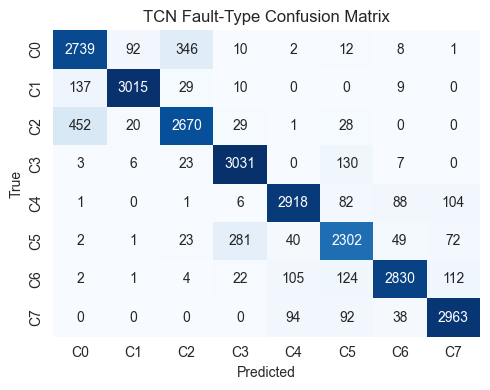

In [94]:
plt.figure(figsize=(5,4))
sns.heatmap(cm,
            annot=True, fmt='d',
            cmap='Blues',
            cbar=False,
            xticklabels=[f'C{i}' for i in range(cm.shape[0])],
            yticklabels=[f'C{i}' for i in range(cm.shape[0])])
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('TCN Fault-Type Confusion Matrix'); plt.tight_layout(); plt.show()

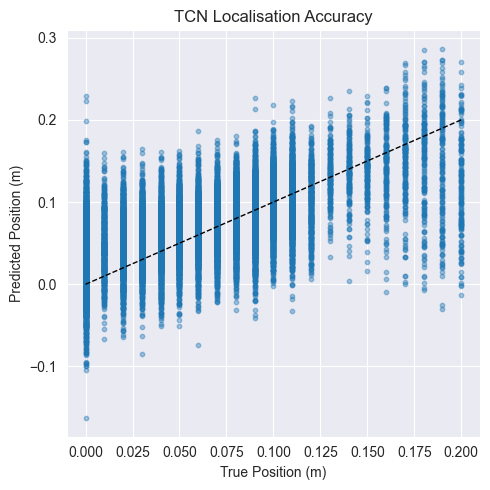

In [95]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seq_len = X_test_tensor.shape[1]           # 31
n_classes = 8                              # healthy + 7 faults
tcn = OTDR_TCN(in_ch=1,
               mid_ch=64,
               n_blocks=6,
               k=3,
               n_classes=n_classes).to(device)
tcn.load_state_dict(torch.load('models/best_tcn.pt', map_location=device, weights_only=True))
tcn.eval()

test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_pos_test_tensor.squeeze(-1)),
    batch_size=256
)

all_preds_loc, all_true_loc = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        # TCN expects (B, 1, L)
        _, loc_hat = tcn(xb.unsqueeze(1).to(device))
        all_preds_loc.append(loc_hat.cpu())
        all_true_loc.append(yb)

all_preds_loc = torch.cat(all_preds_loc).numpy()
all_true_loc  = torch.cat(all_true_loc).numpy()


plt.figure(figsize=(5, 5))
plt.scatter(all_true_loc, all_preds_loc, alpha=0.4, s=10)
lims = [all_true_loc.min(), all_true_loc.max()]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlabel('True Position (m)')
plt.ylabel('Predicted Position (m)')
plt.title('TCN Localisation Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()


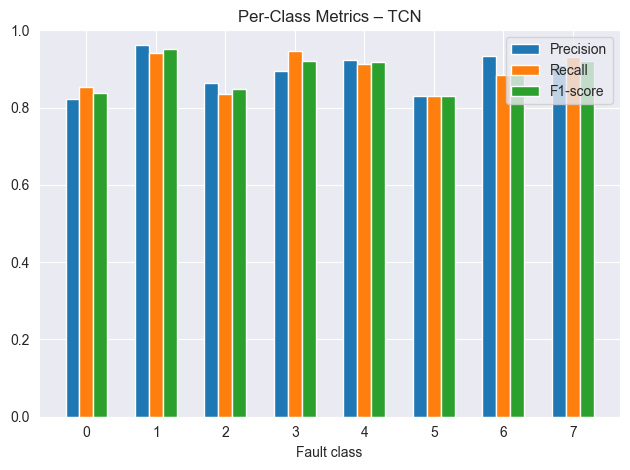

In [98]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support


# bar chart of precision, recall, F1
prec, rec, f1, _ = precision_recall_fscore_support(all_true_cls, all_preds_cls, zero_division=0)
x = np.arange(n_fault_classes)
plt.figure()
plt.bar(x-0.2, prec, width=0.2, label='Precision')
plt.bar(x,     rec,  width=0.2, label='Recall')
plt.bar(x+0.2, f1,   width=0.2, label='F1-score')
plt.xticks(x)
plt.xlabel('Fault class')
plt.ylim(0, 1)
plt.title('Per-Class Metrics – TCN')
plt.legend()
plt.tight_layout()
plt.show()


## Time Series Transformer Model

In [99]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, seq_len=31, d_model=128, n_heads=4, n_layers=4,
                 dim_feedforward=256, dropout=0.1, n_classes=4):
        super().__init__()
        self.seq_len = seq_len
        # scalar amplitude → d_model
        self.input_proj = nn.Linear(1, d_model)

        # learnable positional encodings
        self.pos_embed = nn.Parameter(torch.randn(seq_len, d_model))

        # vanilla encoder stack
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                               nhead=n_heads,
                                               dim_feedforward=dim_feedforward,
                                               dropout=dropout,
                                               batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        # task heads
        self.cls_head = nn.Linear(d_model, n_classes)
        self.loc_head = nn.Linear(d_model, 1)

        # initialisation (Xavier)
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv1d)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim() == 3:           # (B, 1, L)
            x = x.squeeze(1)
        B, L = x.shape             # expect L == seq_len
        x = x.unsqueeze(-1)        # (B, L, 1)
        h = self.input_proj(x)     # (B, L, d_model)
        h = h + self.pos_embed[None, :, :]  # add positional enc.

        h = self.encoder(h)        # (B, L, d_model)
        h = h.mean(dim=1)          # global average pooling

        return self.cls_head(h), self.loc_head(h).squeeze(-1)


Transformer training:

In [100]:
seq_len        = X_train_tensor.shape[1]          # 31
n_fault_classes = int(y_class_train_tensor.max() + 1)

tst = TimeSeriesTransformer(seq_len=seq_len,
                            d_model=128,
                            n_heads=4,
                            n_layers=4,
                            dim_feedforward=256,
                            dropout=0.1,
                            n_classes=n_fault_classes).to(device)

criterion_cls = nn.CrossEntropyLoss()
criterion_loc = nn.MSELoss()
lambda_loc    = 0.5                     # weight for regression term

opt_tst = torch.optim.AdamW(tst.parameters(), lr=2e-4, weight_decay=1e-2)

sch_tst = torch.optim.lr_scheduler.StepLR(opt_tst, step_size=15, gamma=0.5)


In [101]:
n_epochs_tst   = 60
best_val_loss  = float('inf')
patience, pat_max = 0, 10

for epoch in trange(n_epochs_tst, desc='TST'):
    # training loop
    tst.train()
    tr_loss = 0.
    for x, y_cls, y_loc in train_loader:
        x   = x.to(device)
        y_c = y_cls.to(device)
        y_l = y_loc.to(device)

        logits, p_loc = tst(x)
        loss = criterion_cls(logits, y_c) + lambda_loc * criterion_loc(p_loc, y_l)

        opt_tst.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(tst.parameters(), 1.0)
        opt_tst.step()
        tr_loss += loss.item() * x.size(0)

    # validation
    tst.eval()
    val_loss, val_corr, val_samp, val_mse = 0., 0, 0, 0.
    with torch.no_grad():
        for x, y_cls, y_loc in val_loader:
            x, y_c, y_l = x.to(device), y_cls.to(device), y_loc.to(device)
            logits, p_loc = tst(x)
            loss = criterion_cls(logits, y_c) + lambda_loc * criterion_loc(p_loc, y_l)

            val_loss += loss.item() * x.size(0)
            val_corr += (logits.argmax(1) == y_c).sum().item()
            val_mse  += criterion_loc(p_loc, y_l).item() * x.size(0)
            val_samp += x.size(0)

    val_loss /= val_samp
    val_acc   = val_corr / val_samp
    val_rmse  = (val_mse / val_samp) ** 0.5

    print(f'Epoch {epoch+1:02d} | trL={tr_loss/len(train_ds):.4f} | '
          f'valL={val_loss:.4f} | valAcc={val_acc:.3f} | valRMSE={val_rmse:.3f}')

    sch_tst.step()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(tst.state_dict(), 'models/best_tst.pt')
        patience = 0
    else:
        patience += 1
        if patience >= pat_max:
            print('Early stopping.')
            break


TST:   2%|▏         | 1/60 [00:05<05:43,  5.82s/it]

Epoch 01 | trL=1.0624 | valL=0.6040 | valAcc=0.767 | valRMSE=0.078


TST:   3%|▎         | 2/60 [00:11<05:35,  5.78s/it]

Epoch 02 | trL=0.5792 | valL=0.4891 | valAcc=0.810 | valRMSE=0.052


TST:   5%|▌         | 3/60 [00:16<05:17,  5.56s/it]

Epoch 03 | trL=0.5034 | valL=0.4360 | valAcc=0.824 | valRMSE=0.057


TST:   7%|▋         | 4/60 [00:22<05:05,  5.46s/it]

Epoch 04 | trL=0.4567 | valL=0.4421 | valAcc=0.817 | valRMSE=0.057


TST:   8%|▊         | 5/60 [00:27<04:57,  5.40s/it]

Epoch 05 | trL=0.4336 | valL=0.3981 | valAcc=0.834 | valRMSE=0.042


TST:  10%|█         | 6/60 [00:32<04:51,  5.39s/it]

Epoch 06 | trL=0.4184 | valL=0.4078 | valAcc=0.830 | valRMSE=0.041


TST:  12%|█▏        | 7/60 [00:38<04:45,  5.38s/it]

Epoch 07 | trL=0.4012 | valL=0.3942 | valAcc=0.835 | valRMSE=0.043


TST:  13%|█▎        | 8/60 [00:43<04:43,  5.46s/it]

Epoch 08 | trL=0.3897 | valL=0.3640 | valAcc=0.845 | valRMSE=0.042


TST:  15%|█▌        | 9/60 [00:49<04:36,  5.42s/it]

Epoch 09 | trL=0.3823 | valL=0.3651 | valAcc=0.849 | valRMSE=0.038


TST:  17%|█▋        | 10/60 [00:54<04:30,  5.41s/it]

Epoch 10 | trL=0.3699 | valL=0.3479 | valAcc=0.850 | valRMSE=0.040


TST:  18%|█▊        | 11/60 [00:59<04:23,  5.38s/it]

Epoch 11 | trL=0.3662 | valL=0.3435 | valAcc=0.853 | valRMSE=0.036


TST:  20%|██        | 12/60 [01:05<04:20,  5.42s/it]

Epoch 12 | trL=0.3570 | valL=0.3396 | valAcc=0.855 | valRMSE=0.038


TST:  22%|██▏       | 13/60 [01:11<04:18,  5.50s/it]

Epoch 13 | trL=0.3480 | valL=0.3412 | valAcc=0.856 | valRMSE=0.039


TST:  23%|██▎       | 14/60 [01:16<04:10,  5.45s/it]

Epoch 14 | trL=0.3475 | valL=0.3341 | valAcc=0.860 | valRMSE=0.034


TST:  25%|██▌       | 15/60 [01:21<04:05,  5.47s/it]

Epoch 15 | trL=0.3433 | valL=0.3401 | valAcc=0.856 | valRMSE=0.036


TST:  27%|██▋       | 16/60 [01:27<03:57,  5.40s/it]

Epoch 16 | trL=0.3249 | valL=0.3352 | valAcc=0.857 | valRMSE=0.032


TST:  28%|██▊       | 17/60 [01:32<03:50,  5.36s/it]

Epoch 17 | trL=0.3225 | valL=0.3161 | valAcc=0.865 | valRMSE=0.031


TST:  30%|███       | 18/60 [01:37<03:45,  5.36s/it]

Epoch 18 | trL=0.3200 | valL=0.3156 | valAcc=0.865 | valRMSE=0.031


TST:  32%|███▏      | 19/60 [01:43<03:41,  5.39s/it]

Epoch 19 | trL=0.3149 | valL=0.3087 | valAcc=0.869 | valRMSE=0.032


TST:  33%|███▎      | 20/60 [01:48<03:33,  5.34s/it]

Epoch 20 | trL=0.3133 | valL=0.3107 | valAcc=0.869 | valRMSE=0.032


TST:  35%|███▌      | 21/60 [01:53<03:27,  5.32s/it]

Epoch 21 | trL=0.3127 | valL=0.3191 | valAcc=0.864 | valRMSE=0.032


TST:  37%|███▋      | 22/60 [01:59<03:23,  5.36s/it]

Epoch 22 | trL=0.3106 | valL=0.3160 | valAcc=0.865 | valRMSE=0.031


TST:  38%|███▊      | 23/60 [02:04<03:20,  5.41s/it]

Epoch 23 | trL=0.3098 | valL=0.3103 | valAcc=0.868 | valRMSE=0.030


TST:  40%|████      | 24/60 [02:10<03:13,  5.38s/it]

Epoch 24 | trL=0.3061 | valL=0.3097 | valAcc=0.872 | valRMSE=0.031


TST:  42%|████▏     | 25/60 [02:15<03:07,  5.36s/it]

Epoch 25 | trL=0.3054 | valL=0.3060 | valAcc=0.872 | valRMSE=0.030


TST:  43%|████▎     | 26/60 [02:20<03:00,  5.32s/it]

Epoch 26 | trL=0.3034 | valL=0.3149 | valAcc=0.869 | valRMSE=0.030


TST:  45%|████▌     | 27/60 [02:25<02:54,  5.29s/it]

Epoch 27 | trL=0.3011 | valL=0.2974 | valAcc=0.873 | valRMSE=0.030


TST:  47%|████▋     | 28/60 [02:31<02:51,  5.35s/it]

Epoch 28 | trL=0.2990 | valL=0.3108 | valAcc=0.870 | valRMSE=0.029


TST:  48%|████▊     | 29/60 [02:36<02:45,  5.34s/it]

Epoch 29 | trL=0.2960 | valL=0.3116 | valAcc=0.873 | valRMSE=0.032


TST:  50%|█████     | 30/60 [02:41<02:40,  5.34s/it]

Epoch 30 | trL=0.2966 | valL=0.3119 | valAcc=0.871 | valRMSE=0.030


TST:  52%|█████▏    | 31/60 [02:47<02:34,  5.33s/it]

Epoch 31 | trL=0.2877 | valL=0.2972 | valAcc=0.876 | valRMSE=0.029


TST:  53%|█████▎    | 32/60 [02:52<02:28,  5.32s/it]

Epoch 32 | trL=0.2856 | valL=0.2954 | valAcc=0.877 | valRMSE=0.029


TST:  55%|█████▌    | 33/60 [02:57<02:23,  5.31s/it]

Epoch 33 | trL=0.2843 | valL=0.2926 | valAcc=0.876 | valRMSE=0.030


TST:  57%|█████▋    | 34/60 [03:03<02:18,  5.31s/it]

Epoch 34 | trL=0.2850 | valL=0.2956 | valAcc=0.877 | valRMSE=0.029


TST:  58%|█████▊    | 35/60 [03:08<02:14,  5.37s/it]

Epoch 35 | trL=0.2830 | valL=0.2934 | valAcc=0.877 | valRMSE=0.029


TST:  60%|██████    | 36/60 [03:13<02:08,  5.35s/it]

Epoch 36 | trL=0.2812 | valL=0.2960 | valAcc=0.877 | valRMSE=0.029


TST:  62%|██████▏   | 37/60 [03:19<02:02,  5.34s/it]

Epoch 37 | trL=0.2805 | valL=0.2976 | valAcc=0.877 | valRMSE=0.030


TST:  63%|██████▎   | 38/60 [03:24<01:56,  5.31s/it]

Epoch 38 | trL=0.2816 | valL=0.2937 | valAcc=0.877 | valRMSE=0.029


TST:  65%|██████▌   | 39/60 [03:29<01:51,  5.32s/it]

Epoch 39 | trL=0.2801 | valL=0.2901 | valAcc=0.880 | valRMSE=0.030


TST:  67%|██████▋   | 40/60 [03:35<01:45,  5.30s/it]

Epoch 40 | trL=0.2778 | valL=0.2996 | valAcc=0.876 | valRMSE=0.029


TST:  68%|██████▊   | 41/60 [03:40<01:41,  5.35s/it]

Epoch 41 | trL=0.2785 | valL=0.2904 | valAcc=0.878 | valRMSE=0.030


TST:  70%|███████   | 42/60 [03:46<01:37,  5.44s/it]

Epoch 42 | trL=0.2764 | valL=0.2937 | valAcc=0.878 | valRMSE=0.029


TST:  72%|███████▏  | 43/60 [03:51<01:32,  5.42s/it]

Epoch 43 | trL=0.2765 | valL=0.2874 | valAcc=0.880 | valRMSE=0.029


TST:  73%|███████▎  | 44/60 [03:56<01:25,  5.37s/it]

Epoch 44 | trL=0.2755 | valL=0.2925 | valAcc=0.878 | valRMSE=0.029


TST:  75%|███████▌  | 45/60 [04:02<01:20,  5.34s/it]

Epoch 45 | trL=0.2753 | valL=0.2933 | valAcc=0.877 | valRMSE=0.029


TST:  77%|███████▋  | 46/60 [04:07<01:14,  5.34s/it]

Epoch 46 | trL=0.2703 | valL=0.2884 | valAcc=0.879 | valRMSE=0.029


TST:  78%|███████▊  | 47/60 [04:12<01:09,  5.32s/it]

Epoch 47 | trL=0.2697 | valL=0.2900 | valAcc=0.880 | valRMSE=0.029


TST:  80%|████████  | 48/60 [04:18<01:03,  5.32s/it]

Epoch 48 | trL=0.2689 | valL=0.2888 | valAcc=0.880 | valRMSE=0.028


TST:  82%|████████▏ | 49/60 [04:23<00:59,  5.38s/it]

Epoch 49 | trL=0.2677 | valL=0.2937 | valAcc=0.878 | valRMSE=0.029


TST:  83%|████████▎ | 50/60 [04:28<00:53,  5.34s/it]

Epoch 50 | trL=0.2677 | valL=0.2977 | valAcc=0.877 | valRMSE=0.029


TST:  85%|████████▌ | 51/60 [04:34<00:47,  5.32s/it]

Epoch 51 | trL=0.2680 | valL=0.2947 | valAcc=0.879 | valRMSE=0.029


TST:  87%|████████▋ | 52/60 [04:39<00:42,  5.32s/it]

Epoch 52 | trL=0.2668 | valL=0.2865 | valAcc=0.881 | valRMSE=0.029


TST:  88%|████████▊ | 53/60 [04:44<00:37,  5.32s/it]

Epoch 53 | trL=0.2674 | valL=0.2882 | valAcc=0.879 | valRMSE=0.029


TST:  90%|█████████ | 54/60 [04:50<00:32,  5.43s/it]

Epoch 54 | trL=0.2664 | valL=0.2924 | valAcc=0.879 | valRMSE=0.029


TST:  92%|█████████▏| 55/60 [04:55<00:27,  5.42s/it]

Epoch 55 | trL=0.2662 | valL=0.2863 | valAcc=0.879 | valRMSE=0.029


TST:  93%|█████████▎| 56/60 [05:01<00:21,  5.45s/it]

Epoch 56 | trL=0.2647 | valL=0.2892 | valAcc=0.881 | valRMSE=0.029


TST:  95%|█████████▌| 57/60 [05:06<00:16,  5.40s/it]

Epoch 57 | trL=0.2656 | valL=0.2943 | valAcc=0.879 | valRMSE=0.029


TST:  97%|█████████▋| 58/60 [05:11<00:10,  5.38s/it]

Epoch 58 | trL=0.2645 | valL=0.2891 | valAcc=0.881 | valRMSE=0.029


TST:  98%|█████████▊| 59/60 [05:17<00:05,  5.37s/it]

Epoch 59 | trL=0.2647 | valL=0.2912 | valAcc=0.879 | valRMSE=0.029


TST: 100%|██████████| 60/60 [05:22<00:00,  5.38s/it]

Epoch 60 | trL=0.2636 | valL=0.2938 | valAcc=0.879 | valRMSE=0.028


Transformer Evaluation:

In [102]:
tst.load_state_dict(torch.load('models/best_tst.pt', map_location=device, weights_only=True))
tst.eval()

test_loader = DataLoader(test_ds, batch_size=256)

test_corr, test_samp, test_mse = 0, 0, 0.
with torch.no_grad():
    for x, y_cls, y_loc in test_loader:
        x, y_c, y_l = x.to(device), y_cls.to(device), y_loc.to(device)
        logits, p_loc = tst(x)

        test_corr += (logits.argmax(1) == y_c).sum().item()
        test_mse  += criterion_loc(p_loc, y_l).item() * x.size(0)
        test_samp += x.size(0)

test_acc  = test_corr / test_samp
test_rmse = (test_mse / test_samp) ** 0.5
print(f'Transformer – Test Acc = {test_acc:.3f} | Test RMSE = {test_rmse:.3f}')


Transformer – Test Acc = 0.882 | Test RMSE = 0.028


              precision    recall  f1-score   support

           0      0.835     0.781     0.807      3210
           1      0.949     0.947     0.948      3200
           2      0.817     0.850     0.833      3200
           3      0.885     0.938     0.911      3200
           4      0.915     0.923     0.919      3200
           5      0.776     0.829     0.801      2770
           6      0.949     0.865     0.905      3200
           7      0.927     0.915     0.921      3187

    accuracy                          0.882     25167
   macro avg      0.882     0.881     0.881     25167
weighted avg      0.883     0.882     0.882     25167



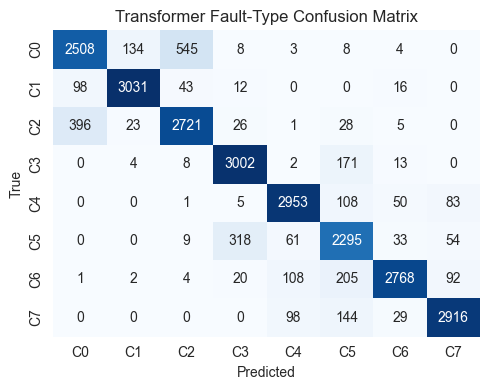

In [103]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Gather all predictions and true labels
all_preds_cls = []
all_true_cls = []

tst.eval()
with torch.no_grad():
    for x, y_cls, _ in test_loader:
        x = x.to(device)
        logits, _ = tst(x)
        preds = logits.argmax(dim=1)
        all_preds_cls.extend(preds.cpu().tolist())
        all_true_cls.extend(y_cls.tolist())

# Compute metrics
cm = confusion_matrix(all_true_cls, all_preds_cls)
report = classification_report(all_true_cls, all_preds_cls, digits=3)
print(report)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=[f'C{i}' for i in range(cm.shape[0])],
    yticklabels=[f'C{i}' for i in range(cm.shape[0])]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Transformer Fault-Type Confusion Matrix')
plt.tight_layout()
plt.show()


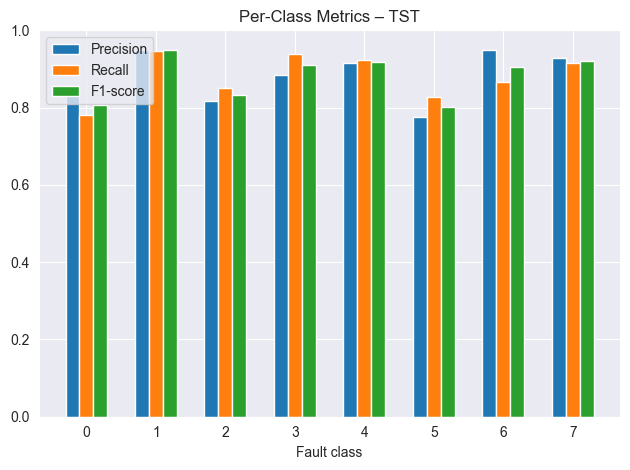

In [115]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support


# bar chart of precision, recall, F1
prec, rec, f1, _ = precision_recall_fscore_support(all_true_cls, all_preds_cls, zero_division=0)
x = np.arange(n_fault_classes)

plt.figure()
plt.bar(x-0.2, prec, width=0.2, label='Precision')
plt.bar(x,     rec,  width=0.2, label='Recall')
plt.bar(x+0.2, f1,   width=0.2, label='F1-score')
plt.xticks(x)
plt.xlabel('Fault class')
plt.ylim(0, 1)
plt.title('Per-Class Metrics – TST')
plt.legend()
plt.tight_layout()
plt.show()


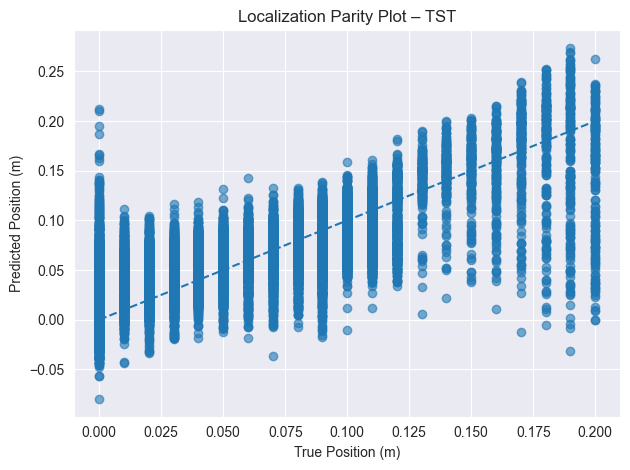

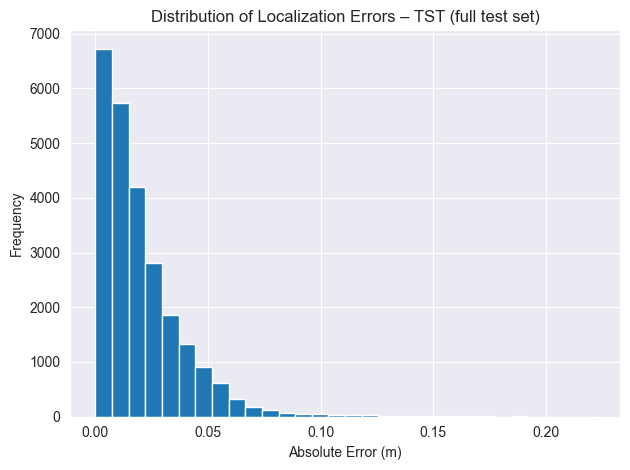

Localization RMSE on full test set: 0.028 m


In [105]:
import torch, matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seq_len = X_test_tensor.shape[1]          # 31
n_classes = 8                             # healthy + 7 faults
tst = TimeSeriesTransformer(seq_len=seq_len,
                            d_model=128,
                            n_heads=4,
                            n_layers=4,
                            dim_feedforward=256,
                            dropout=0.1,
                            n_classes=n_classes).to(device)
tst.load_state_dict(torch.load('models/best_tst.pt', map_location=device, weights_only=True))
tst.eval()

# 2) Forward-pass on the full test set
test_loader = DataLoader(TensorDataset(X_test_tensor,
                                       y_pos_test_tensor.squeeze(-1)),
                         batch_size=256)

pos_pred, y_pos_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        _, p_hat = tst(xb)               # p_hat shape: (B,)
        pos_pred.append(p_hat.cpu())
        y_pos_true.append(yb)

pos_pred   = torch.cat(pos_pred)
y_pos_true = torch.cat(y_pos_true)

# Parity plot
plt.figure()
plt.scatter(y_pos_true, pos_pred, alpha=0.6)
lims = [float(y_pos_true.min()), float(y_pos_true.max())]
plt.plot(lims, lims, linestyle='--')
plt.xlabel('True Position (m)')
plt.ylabel('Predicted Position (m)')
plt.title('Localization Parity Plot – TST')
plt.tight_layout()
plt.show()

# Histogram of absolute errors
abs_err = (pos_pred - y_pos_true).abs()

plt.figure()
plt.hist(abs_err.numpy(), bins=30)
plt.xlabel('Absolute Error (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Localization Errors – TST (full test set)')
plt.tight_layout()
plt.show()

tst_rmse = float(torch.sqrt((abs_err ** 2).mean()))
print(f'Localization RMSE on full test set: {tst_rmse:.3f} m')


### Full Pipeline (GRU-AE to TST):

In [106]:
def gru_ae_detect(tensor, batch_size=64, threshold=0.1):
    if isinstance(tensor, np.ndarray):
        tensor = torch.from_numpy(tensor).float()

    errs = []
    with torch.no_grad():
        for i in range(0, tensor.shape[0], batch_size):
            x = tensor[i:i+batch_size].unsqueeze(1).to(device)
            recon = ae(x)
            # reconstruction error
            err = torch.mean((x - recon) ** 2, dim=(1, 2))
            errs.append(err)

    errs = torch.cat(errs)
    return errs > threshold          # boolean mask

anomaly_mask = gru_ae_detect(X_test, threshold=threshold)
fault_idx = anomaly_mask.nonzero(as_tuple=True)[0]

print(f"Detected {fault_idx.numel()} anomalies out of {X_test.shape[0]} test traces "
      f"({fault_idx.numel() / X_test.shape[0]:.1%}).")

Detected 7169 anomalies out of 25167 test traces (28.5%).


In [107]:
tst.load_state_dict(torch.load('models/best_tst.pt', map_location=device, weights_only=True))
tst.eval()
fault_idx = fault_idx.cpu()
X_fault = X_test_tensor[fault_idx]
y_class_fault = y_class_test_tensor[fault_idx]
y_pos_fault = y_pos_test_tensor[fault_idx]


fault_loader = DataLoader(TensorDataset(X_fault, y_class_fault, y_pos_fault),
                          batch_size=256)

In [108]:
logits_all, pos_pred_all = [], []
with torch.no_grad():
    for xb, _, _ in fault_loader:
        preds_cls, preds_pos = tst(xb.to(device))
        logits_all.append(preds_cls.cpu())
        pos_pred_all.append(preds_pos.cpu())

y_pred_cls = torch.cat(logits_all).argmax(1)
y_true_cls = y_class_fault
pos_pred   = torch.cat(pos_pred_all)


Visualising the Transformer model's performance:

In [109]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
print(classification_report(y_true_cls,
                            y_pred_cls,
                            digits=3,
                            target_names=[f'Class {i}' for i in range(0, int(y_true_cls.max()+1))]))

              precision    recall  f1-score   support

     Class 0      0.750     0.630     0.685       219
     Class 1      0.967     0.918     0.942       220
     Class 2      0.932     0.963     0.947      1135
     Class 3      0.821     0.906     0.861       384
     Class 4      0.996     0.988     0.992       683
     Class 5      0.933     0.907     0.920       795
     Class 6      0.999     0.990     0.994      1658
     Class 7      0.993     0.998     0.995      2075

    accuracy                          0.961      7169
   macro avg      0.924     0.913     0.917      7169
weighted avg      0.961     0.961     0.960      7169



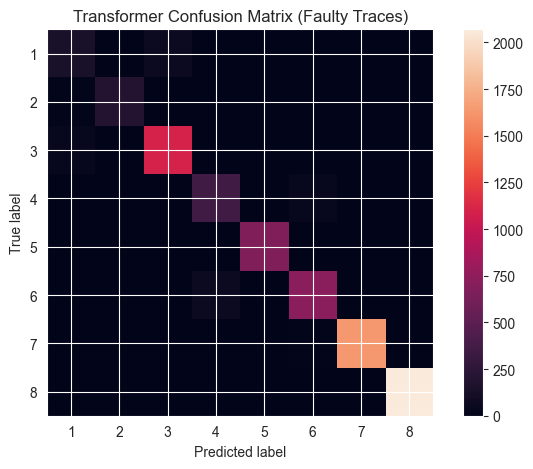

In [110]:
cm = confusion_matrix(y_true_cls, y_pred_cls)
n_fault_classes = cm.shape[0]

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Transformer Confusion Matrix (Faulty Traces)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()
tick = np.arange(n_fault_classes)
plt.xticks(tick, tick+1)
plt.yticks(tick, tick+1)
plt.tight_layout()
plt.show()

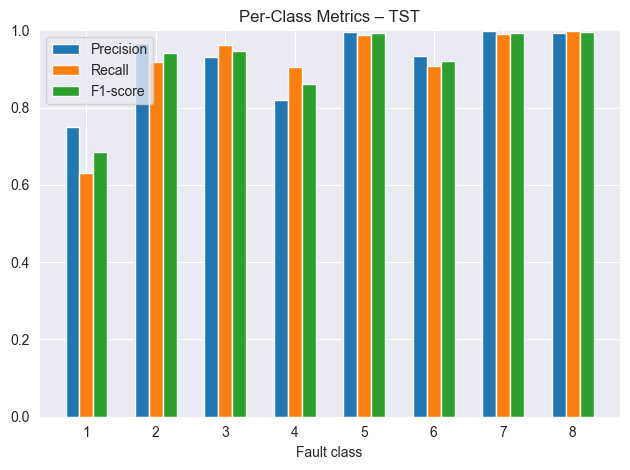

In [111]:
# bar chart of precision, recall, F1
prec, rec, f1, _ = precision_recall_fscore_support(y_true_cls, y_pred_cls, zero_division=0)
x = np.arange(n_fault_classes)

plt.figure()
plt.bar(x-0.2, prec, width=0.2, label='Precision')
plt.bar(x,     rec,  width=0.2, label='Recall')
plt.bar(x+0.2, f1,   width=0.2, label='F1-score')
plt.xticks(x)
plt.xlabel('Fault class')
plt.ylim(0, 1)
plt.title('Per-Class Metrics – TST')
plt.legend()
plt.tight_layout()
plt.show()


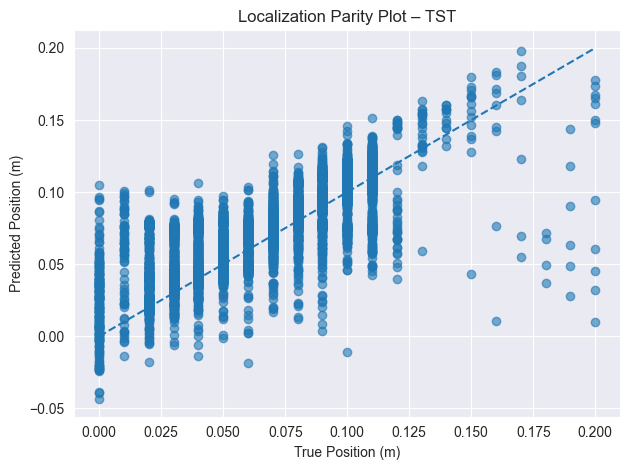

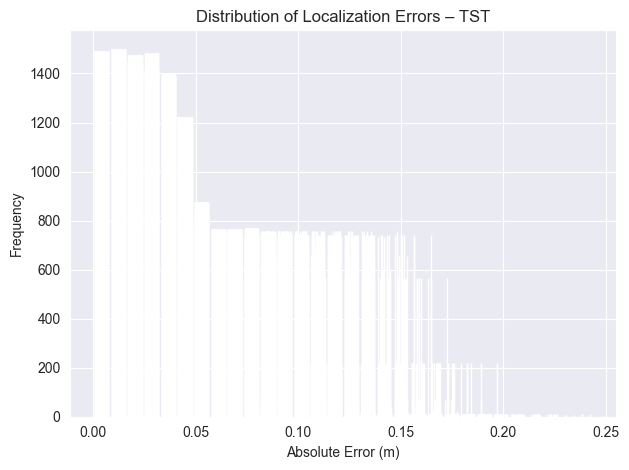

Localization RMSE on detected faults: 0.045 m


In [112]:
# Parity plot
plt.figure()
plt.scatter(y_pos_fault, pos_pred, alpha=0.6)
lims = [float(y_pos_fault.min()), float(y_pos_fault.max())]
plt.plot(lims, lims, linestyle='--')
plt.xlabel('True Position (m)')
plt.ylabel('Predicted Position (m)')
plt.title('Localization Parity Plot – TST')
plt.tight_layout()
plt.show()

# Histogram of absolute errors
abs_err = (pos_pred - y_pos_fault).abs()

plt.figure()
plt.hist(abs_err.numpy(), bins=30)
plt.xlabel('Absolute Error (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Localization Errors – TST')
plt.tight_layout()
plt.show()

rmse = float(torch.sqrt((abs_err**2).mean()))
print(f'Localization RMSE on detected faults: {rmse:.3f} m')


In [113]:
def reconstruction_errors(batch_X, bs=256):
    ae.eval()
    errs = []
    with torch.no_grad():
        for i in range(0, batch_X.size(0), bs):
            chunk = batch_X[i:i+bs]
            x = chunk.unsqueeze(1).to(device)               # (B,1,feat_dim)
            recon = ae(x)
            mse   = (recon - x).pow(2).mean(dim=(1, 2))

            errs.append(mse.cpu())

    return torch.cat(errs)

def detect(batch_X, thresh=threshold):
    return reconstruction_errors(batch_X) > thresh

# Ground-truth vs detected faults
NORMAL_LABEL = 0

gt_fault_mask = (y_class_test_tensor != NORMAL_LABEL)
n_gt_faults   = gt_fault_mask.sum().item()
print(f"Ground-truth faults in test set : {n_gt_faults}")

ae_detect_mask = detect(X_test_tensor)
n_detected     = ae_detect_mask.sum().item()
print(f"Faults flagged by GRU-AE       : {n_detected}")

tp = (gt_fault_mask & ae_detect_mask).sum().item()
fp = (~gt_fault_mask & ae_detect_mask).sum().item()
fn = (gt_fault_mask & ~ae_detect_mask).sum().item()

print(f"TP = {tp}  |  FP = {fp}  |  FN = {fn}")

Ground-truth faults in test set : 21957
Faults flagged by GRU-AE       : 7168
TP = 6949  |  FP = 219  |  FN = 15008


Fault Position RMSE on detected faults only for TCN and TST:

In [114]:
import numpy as np
from sklearn.metrics import mean_squared_error

fault_mask_np = (y_pos_test_tensor.squeeze().cpu().numpy() > 0)

true_pos_tcn = all_true_loc[fault_mask_np]
pred_pos_tcn = all_preds_loc[fault_mask_np]

rmse_tcn = np.sqrt(mean_squared_error(true_pos_tcn, pred_pos_tcn))
print(f'TCN RMSE on faults only : {rmse_tcn:.3f} m')
print(f'TST RMSE on faults only : {tst_rmse:.3f} m') # already calculated before

TCN RMSE on faults only : 0.038 m
TST RMSE on faults only : 0.028 m


## SHAP Analysis on TCN

In [116]:
import numpy as np
import torch.nn as nn
import shap

print("SHAP version:", shap.__version__)          # 0.48.0 expected

SHAP version: 0.48.0


In [117]:
RNG_SEED, BG_SIZE, EXP_SIZE = 0, 256, 128
rng = np.random.default_rng(RNG_SEED)
bg_idx  = rng.choice(len(X_train_tensor), BG_SIZE, replace=False)
exp_idx = rng.choice(len(X_test_tensor),  EXP_SIZE, replace=False)

background = X_train_tensor[bg_idx].cpu()   # (BG, 31)
X_exp      = X_test_tensor[exp_idx].cpu()   # (EXP, 31)
N_EXP, N_FEAT = X_exp.shape

In [118]:
#  frozen wrappers around the  TCN
class TCNClassifier(nn.Module):
    def __init__(self, core):
        super().__init__(); self.core = core.eval().cpu()
        for p in self.core.parameters(): p.requires_grad_(False)
    def forward(self, x):                                # x: (B, 31)
        return self.core(x.unsqueeze(1))[0]              # logits (B, C)

class TCNRegressor(nn.Module):
    def __init__(self, core):
        super().__init__(); self.core = core.eval().cpu()
        for p in self.core.parameters(): p.requires_grad_(False)
    def forward(self, x):
        return self.core(x.unsqueeze(1))[1].unsqueeze(1) # (B, 1)

wrap_cls = TCNClassifier(tcn)
wrap_loc = TCNRegressor(tcn)

N_CLASSES = wrap_cls(background[:1]).shape[1]
print(f"Detected {N_CLASSES} fault classes")

class_names = [f"Fault {i}" for i in range(N_CLASSES)]

Detected 8 fault classes


In [119]:
# SHAP explainers
expl_cls = shap.GradientExplainer(wrap_cls, background, batch_size=64)
expl_loc = shap.GradientExplainer(wrap_loc, background, batch_size=64)

raw_cls = expl_cls.shap_values(
    X_exp,
    ranked_outputs=N_CLASSES,       # int, not list
    output_rank_order="max"
)
raw_loc = expl_loc.shap_values(X_exp)

In [120]:
# 3. unwrap tuple for just the SHAP values
if isinstance(raw_cls, tuple):           # (phi, idx)
    raw_cls = raw_cls[0]
if isinstance(raw_loc, tuple):
    raw_loc = raw_loc[0]

In [121]:
# helper function to fix formatting because i can not figure out what format is going where
def to_list_per_class(vals, n_cls, n_exp, n_feat):
    if isinstance(vals, list) and len(vals) == n_cls:
        return [v[:, :n_feat] for v in vals]

    if isinstance(vals, list) and len(vals) == n_exp:
        a0 = vals[0]
        if a0.shape[0] == n_cls:                      # (C, F′)
            stacked = np.stack(vals, axis=1)          # (C, N, F′)
            return [stacked[i, :, :n_feat] for i in range(n_cls)]
        if a0.shape[-1] == n_cls:                     # (F′, C)
            stacked = np.stack(vals, axis=0)          # (N, F′, C)
            return [stacked[:, :n_feat, i] for i in range(n_cls)]

    if isinstance(vals, np.ndarray) and vals.ndim == 3:
        C, N, F = vals.shape
        # (C, N, F′)
        if C == n_cls and N == n_exp:
            return [vals[i, :, :n_feat] for i in range(n_cls)]
        # (N, C, F′)
        if vals.shape[0] == n_exp and vals.shape[1] == n_cls:
            return [vals[:, i, :n_feat] for i in range(n_cls)]
        # (N, F′, C)
        if vals.shape[0] == n_exp and vals.shape[2] == n_cls:
            return [vals[:, :n_feat, i] for i in range(n_cls)]

    raise RuntimeError(f"Unrecognised SHAP φ format → type: {type(vals)}, "
                       f"shape: {np.shape(vals)}")


cls_vals = to_list_per_class(raw_cls, N_CLASSES, N_EXP, N_FEAT)

# Pad any missing class with zeros
while len(cls_vals) < N_CLASSES:
    cls_vals.append(np.zeros((N_EXP, N_FEAT), dtype=np.float32))

In [122]:
if isinstance(raw_loc, list):
    loc_vals = raw_loc[0]
else:
    loc_vals = raw_loc

loc_vals = loc_vals.reshape(N_EXP, N_FEAT)

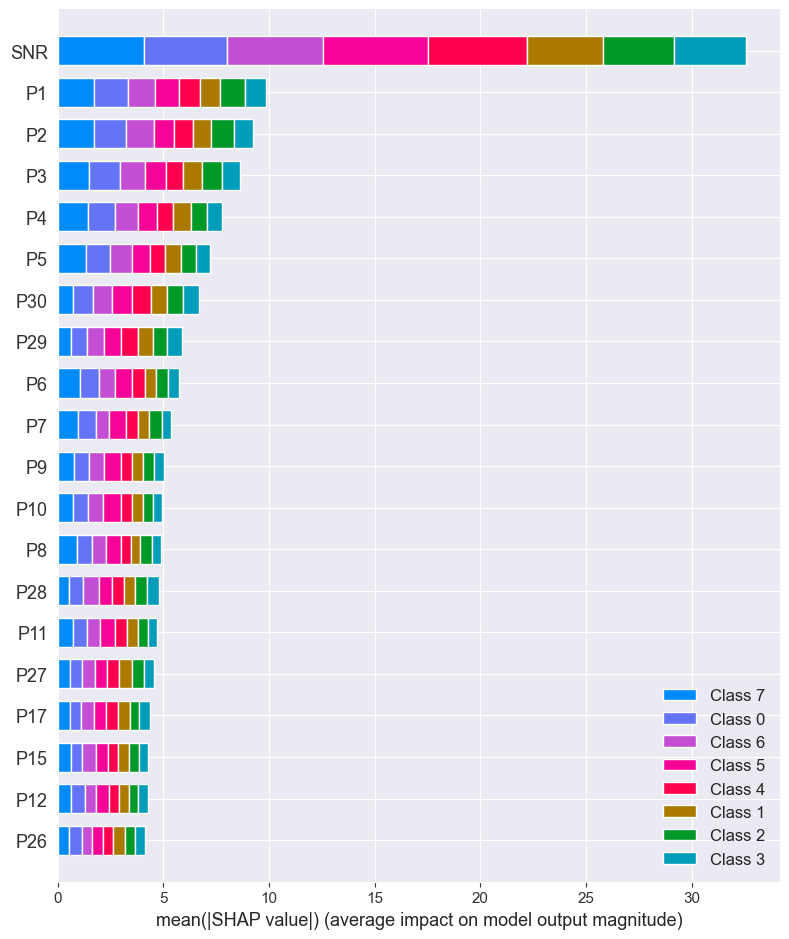

In [123]:
shap.summary_plot(
    cls_vals,
    X_exp.numpy(),
    feature_names=measurement_cols,
    class_names=[f"Class {i}" for i in range(N_CLASSES)],
    show=True
)

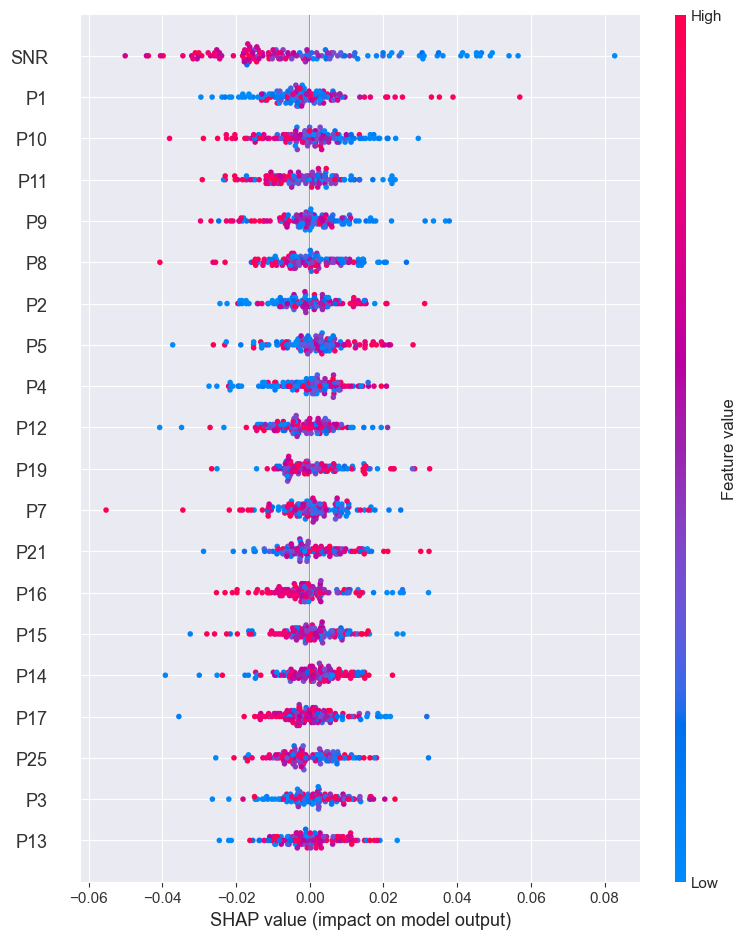

In [124]:
shap.summary_plot(
    loc_vals,
    X_exp.numpy(),
    feature_names=measurement_cols,
    show=True
)

### LLM (ChatGPT o3 model) explanation of SHAP plot:

The SHAP summary reveals a diagnostic model that now pivots chiefly on the global quality indicator of each measurement. **SNR** is by far the most influential feature: higher‐quality traces systematically increase the predicted fault logits, whereas noisy traces pull predictions toward neutrality. This monotonic behaviour mirrors the practical intuition that confident classification is only warranted when the signal exhibits a healthy signal-to-noise ratio.

With distance information removed, the model turns next to the waveform’s boundaries. Amplitude samples at the very start of the trace—**P1, P2, P3**—and at the far end—**P29, P30**—together form the second tier of explanatory power. Elevated reflections in the opening samples tend to nudge the model toward fault types associated with near-end connectors or taps, while strong or attenuated echoes in the closing samples guide it toward faults located deeper in the fibre, such as cuts or bad splices. The clear importance of both edges shows the network has learned to anchor its reasoning on physical reflection patterns rather than on an explicit distance scalar.

Interior points—**P4 through roughly P26**—exert a subtler, fine-tuning influence. Individually they produce only modest SHAP magnitudes, yet their contributions are evenly shared across classes, implying that the dilated convolutions have captured class-specific waveform “textures” distributed throughout the trace. These mid-range features refine the decision once the global SNR and boundary reflections have narrowed the class search space.

Overall, the model now operates with a three-layered logic: (1) assess confidence through SNR; (2) use leading and trailing reflections as primary class cues; (3) refine the verdict through subtle interior-waveform variations. This hierarchy reduces dependence on any single engineered prior, potentially improving generalisation across unseen link topologies, but it also heightens sensitivity to consistent amplitude calibration and temporal alignment in the raw OTDR data.
